# Deep Learning Model
Neste notebook tem os seguintes modelos de aprendizado de máquina comparados:
- LSTM

## Imports

In [5]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import os
import datetime

In [35]:
# os.environ['TENSORBOARD_BINARY'] = '$HOME/projects/artificial_inteligence/venv/bin/tensorboard'

In [36]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

!python3 -m pip list | grep tf
# tb-nightly           1.15.0a20190806

tf-estimator-nightly   2.4.0.dev2020102301
tf-nightly             2.5.0.dev20201126  


In [64]:
# logs_base_dir = "./logs"
# os.makedirs(logs_base_dir, exist_ok=True)
# %tensorboard --logdir {logs_base_dir}

## Prepare Principal Directory

In [37]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}' 

In [38]:
prepare_directory_work(end_directory='notebooks')

'Current working directory: /home/campos/projects/tcc'

## Cell Format

In [39]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Guarantees visualization inside the jupyter
%matplotlib inline

# Print xxxx rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.float_format', '{:.5}'.format)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# pretty print
pp = pprint.PrettyPrinter(indent=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
plt.style.use('seaborn')  # fivethirtyeight
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

## Load Data

In [41]:
%%time

df_vale3 = pd.read_csv('data/cleansing/df_vale3_cleansing.csv',
                        encoding='utf8',
                        delimiter=',',
                        verbose=True)

Tokenization took: 0.62 ms
Type conversion took: 1.40 ms
Parser memory cleanup took: 0.00 ms
CPU times: user 5.94 ms, sys: 454 µs, total: 6.4 ms
Wall time: 5.57 ms


In [42]:
print(df_vale3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2495 non-null   object 
 1   price   2495 non-null   float64
 2   open    2495 non-null   float64
 3   high    2495 non-null   float64
 4   low     2495 non-null   float64
 5   volume  2495 non-null   float64
 6   year    2495 non-null   int64  
 7   month   2495 non-null   int64  
 8   day     2495 non-null   int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 175.6+ KB
None


In [43]:
df_vale3.head()

,date,price,open,high,low,volume,year,month,day
0,2020-06-19,55.17,56.33,56.6,54.71,37.86,2020,6,19
1,2020-06-18,56.17,56.3,56.54,55.61,25.69,2020,6,18
2,2020-06-17,56.2,55.49,56.44,55.15,27.57,2020,6,17
3,2020-06-16,55.39,55.49,55.5,54.22,29.17,2020,6,16
4,2020-06-15,53.88,52.5,54.43,52.13,27.32,2020,6,15


## Columns

In [44]:
df_vale3.columns

Index(['date', 'price', 'open', 'high', 'low', 'volume', 'year', 'month',
       'day'],
      dtype='object')

## Format Date

In [45]:
df_vale3.drop(['date'], axis=1, inplace=True)

---

## Metric to Evaluation

In [46]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

---

## Save Results

In [48]:
dict_results = {}

## Show Results

In [49]:
def show_result_model(df_train, df_test, y_forecast, model_name):
    future_forecast = pd.DataFrame(y_forecast,
                                   index=df_test.index,
                                   columns=['Previsão'])
    mape = mean_absolute_percentage_error(df_test, y_forecast)
    dict_results[model_name] = mape
    
    # plot
    pd.concat([df_train, df_test, future_forecast], axis=1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Time (Days)")
    plt.ylabel("Price (R$)")
    plt.title(f'MAPE = {mape} %')

In [50]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Amazon Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Amazon Stock Price')
    plt.title('Amazon Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Amazon Stock Price')
    plt.legend()
    plt.show()

---

## Train and Test

In [51]:
size_train = int(len(df_vale3)*0.8)
size_test = int(len(df_vale3)*0.2)
print(size_train)
print(size_test)

train = df_vale3.iloc[size_test:]
test = df_vale3.iloc[:size_test]
print(train.shape)
print(test.shape)

1996
499
(1996, 8)
(499, 8)


---

## Normalize Data

In [52]:
train_max = train.max()
train_min = train.min()

train = (train - train_min)/(train_max - train_min)
test = (test - train_min)/(train_max - train_min)

In [53]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    
    return np.array(Xs).astype('float32'), np.array(ys).astype('float32')

In [54]:
time_steps = 30

X_train, y_train = create_dataset(train, train['price'], time_steps)
X_test, y_test = create_dataset(test, test['price'], time_steps)

### Handling index

In [55]:
X_train = X_train[::-1]
y_train = y_train[::-1]

X_test = X_test[::-1]
y_test = y_test[::-1]

---

## LSTM

In [56]:
# sequential model
model_lstm = Sequential(name='lstm_vale3')
model_lstm

#### Input Layer

In [57]:
#Adding the first LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))

#### Hidden Layers

In [58]:
# Adding a second LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))

#### Output Layer

In [59]:
model_lstm.add(Dense(units=1))

### Compile

In [60]:
model_lstm.compile(loss='mean_squared_error',
                   optimizer='adam',
                   metrics=['accuracy'])

### Summary

In [61]:
model_lstm.summary()

Model: "lstm_vale3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30, 50)            11800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                2

### Trainning
- batch_size: cria lote de treinamento de 30 em 30 dias

In [66]:
%%time


history = model_lstm.fit(X_train,
               y_train,
               epochs=1000,
               batch_size=300,
               shuffle=False,
               validation_split=0.1,
               verbose=0)
history

CPU times: user 27.1 s, sys: 2.33 s, total: 29.4 s
Wall time: 7.76 s


In [659]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [679]:
best_epochs = history.history["loss"].index(min(history.history["loss"]))
best_epochs

9976

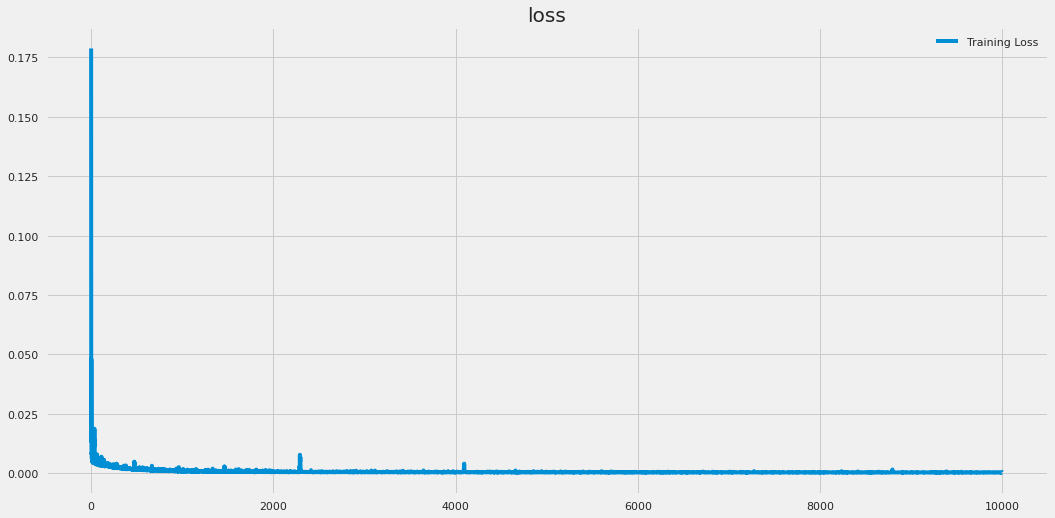

In [681]:
plt.plot(history.history["loss"], label="Training Loss")
plt.title('loss')
plt.legend()
plt.show()

### Predict

In [662]:
y_pred = model_lstm.predict(X_test)

In [663]:
# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]

In [664]:
y_test_lstm = [y_test[row] for row in range(0, len(y_test))]
len(y_test)

469

In [665]:
y_pred_lstm = [y_pred[row][0] for row in range(0, len(y_pred))]
len(y_pred_lstm)

469

In [666]:
mape = mean_absolute_percentage_error(y_test, y_pred_lstm)
dict_results['lstm'] = mape

Text(0.5, 1.0, 'MAPE = 5.942042917013168 %')

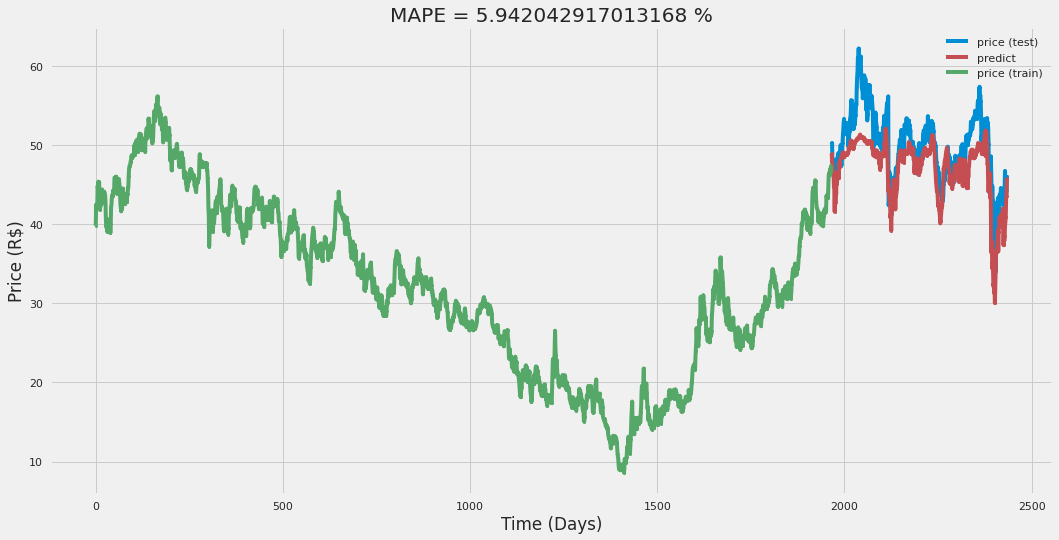

In [667]:
# Plotting the results
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)),
         y_test_lstm,
         marker='.', 
         label="price (test)")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)),
         y_pred_lstm,
         'r',
         marker='.', 
         label="predict")
plt.plot(np.arange(0, len(y_train)), y_train.flatten(),
         'g',
         marker='.', 
         label="price (train)")

plt.legend()
plt.grid(True)
plt.xlabel("Time (Days)")
plt.ylabel("Price (R$)")
plt.title(f'MAPE = {mape} %')

---

## Results

In [678]:
dict_results

{}

---